# Part 1: Getting the data

In [626]:
import json
import sys
import time
from collections import Counter, defaultdict
from datetime import datetime
from tqdm.notebook import trange, tqdm
# disable locks due due random deadlocks
tqdm.get_lock().locks = []
from websockets import ConnectionClosedError
from web3 import Web3

convert_unixtime = lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

In [620]:
INFURA_URL = "https://mainnet.infura.io/v3/87dde21eb7704f8c82f3b51aa58653d0"
INFURA_PROVIDER = "wss://mainnet.infura.io/ws/v3/87dde21eb7704f8c82f3b51aa58653d0"
ETH_USD_PRICE_CONTRACT_ADDR = '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F'
CHAINLINK_ABI = json.loads('[{"constant":false,"inputs":[{"name":"_requestId","type":"bytes32"},{"name":"_payment","type":"uint256"},{"name":"_expiration","type":"uint256"}],"name":"cancelRequest","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[{"name":"","type":"address"}],"name":"authorizedRequesters","outputs":[{"name":"","type":"bool"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"uint256"}],"name":"jobIds","outputs":[{"name":"","type":"bytes32"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"latestAnswer","outputs":[{"name":"","type":"int256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"minimumResponses","outputs":[{"name":"","type":"uint128"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"","type":"uint256"}],"name":"oracles","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_recipient","type":"address"},{"name":"_amount","type":"uint256"}],"name":"transferLINK","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"latestRound","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[{"name":"_clRequestId","type":"bytes32"},{"name":"_response","type":"int256"}],"name":"chainlinkCallback","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[],"name":"renounceOwnership","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"_paymentAmount","type":"uint128"},{"name":"_minimumResponses","type":"uint128"},{"name":"_oracles","type":"address[]"},{"name":"_jobIds","type":"bytes32[]"}],"name":"updateRequestDetails","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"latestTimestamp","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[],"name":"destroy","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":true,"inputs":[],"name":"owner","outputs":[{"name":"","type":"address"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"_roundId","type":"uint256"}],"name":"getAnswer","outputs":[{"name":"","type":"int256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[{"name":"_roundId","type":"uint256"}],"name":"getTimestamp","outputs":[{"name":"","type":"uint256"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":true,"inputs":[],"name":"paymentAmount","outputs":[{"name":"","type":"uint128"}],"payable":false,"stateMutability":"view","type":"function"},{"constant":false,"inputs":[],"name":"requestRateUpdate","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"_requester","type":"address"},{"name":"_allowed","type":"bool"}],"name":"setAuthorization","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"constant":false,"inputs":[{"name":"_newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"payable":false,"stateMutability":"nonpayable","type":"function"},{"inputs":[{"name":"_link","type":"address"},{"name":"_paymentAmount","type":"uint128"},{"name":"_minimumResponses","type":"uint128"},{"name":"_oracles","type":"address[]"},{"name":"_jobIds","type":"bytes32[]"}],"payable":false,"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"name":"response","type":"int256"},{"indexed":true,"name":"answerId","type":"uint256"},{"indexed":true,"name":"sender","type":"address"}],"name":"ResponseReceived","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"previousOwner","type":"address"}],"name":"OwnershipRenounced","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"previousOwner","type":"address"},{"indexed":true,"name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"id","type":"bytes32"}],"name":"ChainlinkRequested","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"id","type":"bytes32"}],"name":"ChainlinkFulfilled","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"id","type":"bytes32"}],"name":"ChainlinkCancelled","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"current","type":"int256"},{"indexed":true,"name":"roundId","type":"uint256"},{"indexed":false,"name":"timestamp","type":"uint256"}],"name":"AnswerUpdated","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"name":"roundId","type":"uint256"},{"indexed":true,"name":"startedBy","type":"address"}],"name":"NewRound","type":"event"}]')

Connect. Might have to run this a few times.

In [621]:
def connect():
    web3 = Web3(Web3.WebsocketProvider(INFURA_PROVIDER))
    contract = web3.eth.contract(ETH_USD_PRICE_CONTRACT_ADDR, abi=CHAINLINK_ABI)
    return web3, contract

web3, contract = connect()

Approximate earliest Ethereum block with response from this price oracle.

In [622]:
first_resp_time = contract.functions.getTimestamp(1).call()
current_time = time.time()
latest_block = web3.eth.getBlock('latest')['number']
# one day has 86400 seconds
days_ago = (current_time - first_resp_time) // 86400
# ~6,000 blocks a day on Ethereum
# to be safe, we'll add a buffer
buffer = 1000
blocks_ago = days_ago * (6000 + buffer)
FIRST_BLOCK = int(latest_block - blocks_ago)
# assert that the first block we've computed does in fact
# occur before the first price contract response
assert web3.eth.getBlock(first_block )['number'] - first_resp_time < 0

Populate `df_answers` with all past oracle responses for this price contract. We do this by querying `ResponseReceived` events.

In [627]:
# get timestamps for each answer
answerID_to_timestamp = {}
print('Getting timestamps...')
time.sleep(1)
latest_round = contract.functions.latestRound().call()
for ans_id in tqdm(range(1, latest_round + 1)):
    ts = contract.functions.getTimestamp(ans_id).call()
    answerID_to_timestamp[ans_id] = ts

Getting timestamps...


In [628]:
def get_all_entries(event, first_block, query=None, chunk_size=500):
    '''
    We query the blockchain in chunks to mitigate disconnection issues.
    
    event - type `web3._utils.datatypes.ResponseReceived`
    first_block - block number where we start querying
    chunk_size - number of contingent blocks we query at a given time.
    '''
    if not query:
        result = []
    else:
        result = {}
        for t in query:
            result[t[-1]] = []
    
    web3, contract = connect()
    
    latest_block = web3.eth.getBlock('latest')['number']
    # query blocks in chunks
    nchunks = (latest_block - first_block) // chunk_size
    print("Querying all past data...")
    time.sleep(1)

    for chunk in tqdm(range(nchunks)):

        start_block = first_block + chunk_size * chunk

        # this shit disconnects often so ...
        # max 100 retries ...
        for i in range(100):
            try:
                filter_ = event.createFilter(
                    fromBlock=start_block,
                    toBlock=start_block + chunk_size,
                )
                entries = filter_.get_all_entries()
                break
            except ConnectionClosedError:
                if i % 10 == 0:
                    print('retrying x{} ...'.format(i))
                time.sleep(1)
                web3, contract = connect()
                continue
        else:
            print('Max retries attempted ... still failed')
            print('Returning partially retrieved data.')
            return result

        for i,entry in enumerate(reversed(entries)):
            if not query:
                result.append(entry)
            else:
                for t in query:
                    d = entry
                    for k in t:
                        d = d[k]
                    result[t[-1]].append(d)

    print('Done.')
    return result

In [630]:
entries = get_all_entries(
    contract.events.ResponseReceived(),
    FIRST_BLOCK,
    query=(('args', 'response'), ('args', 'answerId'), ('args', 'sender')),
    chunk_size=1000
)

Querying all past data...


retrying x0 ...
retrying x10 ...
retrying x20 ...
retrying x30 ...
retrying x40 ...
retrying x50 ...
retrying x60 ...
retrying x70 ...
retrying x80 ...
retrying x90 ...
Max retries attempted ... still failed
Returning partially retrieved data.



In [641]:
# add timestamps
entries['timestamp'] = []
for id_ in entries['answerId']:
    entries['timestamp'].append(answerID_to_timestamp[id_])

df_answers = pd.DataFrame(entries)
df_answers = df_answers.rename(columns={'response': 'price', 'answerId': 'answer_id', 'sender': 'oracle'})

# Part 2: Analyzing the data

In [642]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [643]:
# augment dataframe
# convert timestamp to human readable time
df_answers['date'] = [convert_unixtime(ts) for ts in df_answers['timestamp']]
# convert price into float
df_answers['price_float'] = [p / 1e8 for p in df_answers['price']]

## 2.1 Distribution of price responses per heartbeat, within the last 24 hour

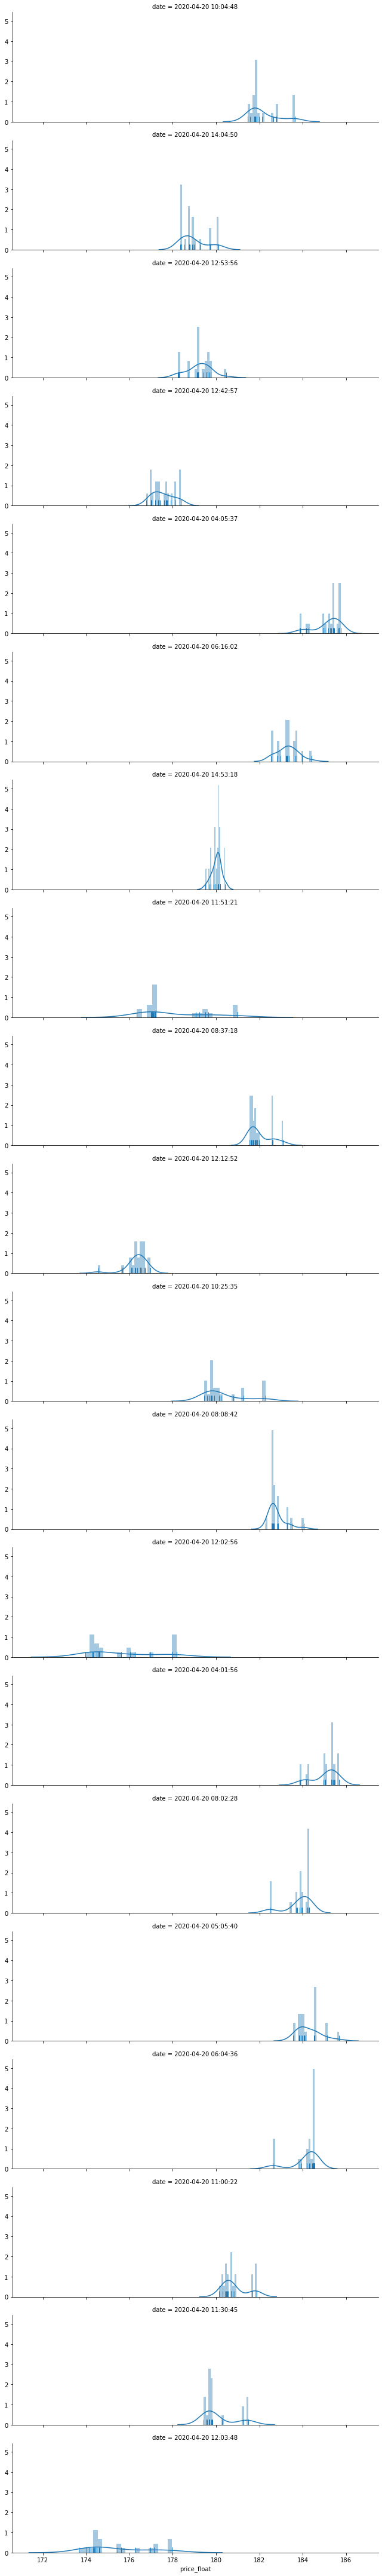

In [649]:
HOURS = 24

ts = time.time() - timedelta(hours=HOURS).total_seconds()
recent_answers = df_answers[df_answers['timestamp']>=ts]
ordered_dates = recent_answers.date.value_counts().index

g = sns.FacetGrid(recent_answers, row="date", row_order=ordered_dates,
                  height=3, aspect=3,)
plot = g.map(sns.distplot, "price_float", rug=True, **{'bins': 20})
plot.savefig("eth_usd_dists.png")

### Observations:
- We can't assume, based on these distributions, that we are dealing with normally distributed data.
    - This is likely due to the fact that we have only ~20 responses. Fitting distributions to small data sets is always a problem.
- Often we'll see what appears to be a **bi-modal distribution**.
    - Could this be a result of prices being reported from different exchanges? i.e. some nodes aren't aggregating reponses, instead they report from one or two sources? I could test this hypothesis if I knew where the oracles were getting their data from.
    - Idea: Oracles that aggregate their responses from multiple exchanges are likely to have responses closer to the mean/median. Penalizing oracles with responses further from the center of the distribution would incentivize oracles to gather information from many sources, which is what we want.
        - Caveat: a weighted average of prices from exchanges, where the weight is a function of *trading volume* is a better aggregation method for price oracles than simple average. This is because prices reported from various exchanges, weighted by the trading volume of those exchanges, is clearly closer to what we envision as the "true price". How do we enforce/incentivise this? Idea: somehow incentivise both accurate (close to mean/median) responses as well as responses representing a large trading volume?

## 2.2 Exploring variance of responses across time

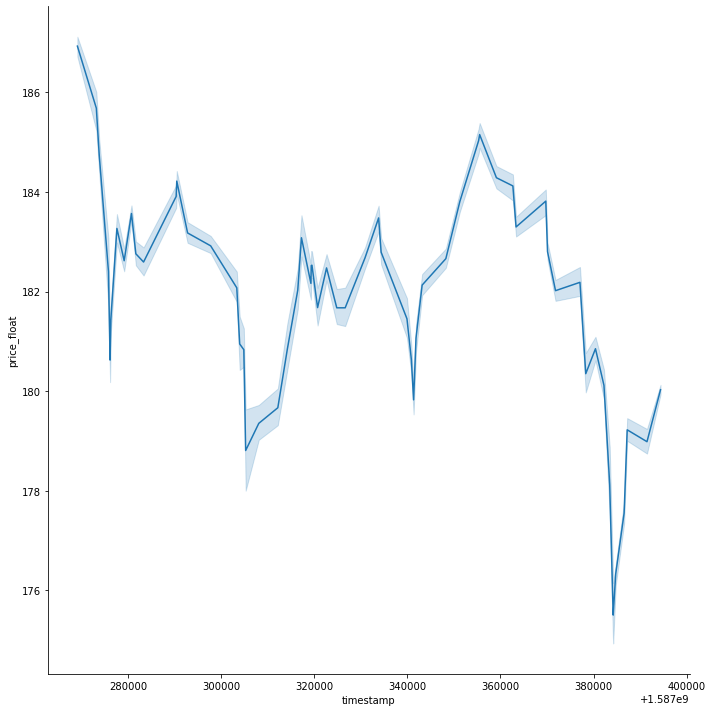

In [653]:
HOURS = 48
ts = time.time() - timedelta(hours=HOURS).total_seconds()
recent_answers = df_answers[df_answers['timestamp']>=ts]

sns.relplot(x="timestamp", y="price_float", kind="line", data=recent_answers,
           height=10, markers=["o"])

### Observations:
- Clearly, variance/deviation varies at different points in time. 

## 2.2.1 Variance of responses as a function of price volatility

Addressing the hypothesis that variance between oracle reponses is largely due to price volatility in the time frame in which the price oracle is reporting.

### Gathering data

In [ ]:
# gathering data
CRYPTO_COMPARE_API_URL = 'https://min-api.cryptocompare.com/data/v2/histominute?fsym={from}&tsym={to}&toTs={ts}'

In [618]:
# get start times of Chainlink requests
entries = get_all_entries(
    contract.events.NewRound(),
    FIRST_BLOCK,
    query=[('blockNumber',), ('args', 'roundId')],
    chunk_size=1000
)
df_startblocks = pd.DataFrame(entries)

# get end times of Chainlink requests
entries = get_all_entries(
    contract.events.AnswerUpdated(),
    FIRST_BLOCK,
    query=[('args', 'roundId'), ('args', 'timestamp')],
    chunk_size=1000
)
df_endtimes = pd.DataFrame(entries)

Querying all past data...
659
Done.
Querying all past data...
659
Done.


In [613]:
entries

,blockNumber,roundId
0,9288036,2
1,9834003,3
2,9837987,4
3,9838959,8
4,9838903,7
...,...,...
271,9905970,274
272,9905892,273
273,9905464,272
274,9905416,271


In [586]:
# match query start times to end times
ts_tuples = []
for startblock, end_ts in zip(sorted(entries.blockNumber.unique()), sorted(df_answers['timestamp'])):
    start_ts = web3.eth.getBlock(int(startblock))['timestamp']
    ts_tuples.append((start_ts, end_ts))

In [588]:
# check matches
for start, end in ts_tuples:
    print((end - start) / 86400)

0.0006944444444444445
-84.02043981481482
-84.63159722222223
-84.6758912037037
-84.70206018518519
-84.77460648148148
-84.7845486111111
-84.86778935185185
-84.90768518518519
-84.95152777777778
-85.03452546296296
-85.11765046296296
-85.20115740740741
-85.26755787037037
-85.28243055555555
-85.28528935185186
-85.28986111111111
-85.3150462962963
-85.33813657407407
-85.36802083333333
-85.4239236111111
-1.4135763888888888
-1.4300810185185184
-1.5132060185185185
-1.5965972222222222
-1.6799421296296295
-1.7313888888888889
-1.7422337962962964
-1.7634027777777779
-1.7647916666666668
-1.7791203703703704
-1.8230324074074074
-1.8473958333333333
-1.8991550925925926
-1.9299421296296295
-1.9795601851851852
-2.011979166666667
-2.01349537037037
-2.0743055555555556
-2.096435185185185
-2.140011574074074
-2.180289351851852
-1.6521643518518518
-1.7352777777777777
-1.7925810185185185
-1.8200347222222222
-1.9023495370370371
-1.9855787037037036
-2.0686342592592593
-2.1519328703703704
-2.1903703703703705
-2.23525

In [568]:
def get_df(from_date, to_date):
    """ Get historical price data between two dates. """
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    # and adding the results to a list. 
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=False, inplace=True)        
    return df

AttributeDict({'difficulty': 2238183701635537,
 'extraData': HexBytes('0x4d696e656420427920416e74506f6f6c20303030'),
 'gasLimit': 9951284,
 'gasUsed': 9938192,
 'hash': HexBytes('0xa30107944667e2788e3387317f00007e62fd1996df75e553a9e0277916cb6312'),
 'logsBloom': HexBytes('0x00000000000000000000000000001000000000000000000000000000000000000000000000000000000000000080000000000000000000010000000000000000000000000100000040000108200004000000000000000000000000000000000000000000000000000000400000000000000014000000000000000010000000000000800000000080000000000000000000100400000800000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002000000000000000000001004000000000000800000020000000000000000000000000000000000000000200000000000000000000800100200000000'),
 'miner': '0x45a36a8e118C37e4c47eF4Ab827A7C9e579E11E2',
 'mixHash': HexBytes('0x3d9f2c3b3f9749a9d7fbab0c05b184cdb151568547dbf255b4945c93ad5964a5'),
 'nonce': HexBytes('0xb6bf1ae3395ea838'),
 'number': 9906683,

In [321]:
def median(x):
    n = len(x)
    if n % 2 == 1:
        return x[n//2]
    else:
        return (x[n//2] + x[n//2 + 1]) / 2 

In [353]:
fmri = sns.load_dataset("fmri")
sns.relplot(x="timepoint", y="signal", kind="line", data=fmri);

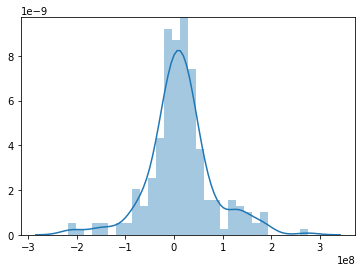

In [337]:
sns.distplot(skews, bins=30)

# Rough Work

In [476]:
for event in contract.events:
    print(event)

<class 'web3._utils.datatypes.ResponseReceived'>
<class 'web3._utils.datatypes.OwnershipRenounced'>
<class 'web3._utils.datatypes.OwnershipTransferred'>
<class 'web3._utils.datatypes.ChainlinkRequested'>
<class 'web3._utils.datatypes.ChainlinkFulfilled'>
<class 'web3._utils.datatypes.ChainlinkCancelled'>
<class 'web3._utils.datatypes.AnswerUpdated'>
<class 'web3._utils.datatypes.NewRound'>


In [629]:
web3, contract = connect()

filter_ = contract.events.ResponseReceived().createFilter(
    fromBlock=start_block,
    toBlock=start_block + chunk_size,
)
entries = filter_.get_all_entries()
entries

[AttributeDict({'args': AttributeDict({'response': 17886711436,
   'answerId': 258,
   'sender': '0x8c85a06EB3854Df0d502B2b00169DBfB8B603Bf3'}),
  'event': 'ResponseReceived',
  'logIndex': 1,
  'transactionIndex': 3,
  'transactionHash': HexBytes('0x2ee9424138a2f63ee8e75777e215dae6bbed82d614831cb007d0ed14182b6e7a'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0xd0e38a9302ff5509636574b2f243a6f1f9f1c712f9ad4e501f7410b05dd4bb36'),
  'blockNumber': 9903835}),
 AttributeDict({'args': AttributeDict({'response': 17939186722,
   'answerId': 258,
   'sender': '0x992Ef8145ab8B3DbFC75523281DaD6A0981891bb'}),
  'event': 'ResponseReceived',
  'logIndex': 5,
  'transactionIndex': 5,
  'transactionHash': HexBytes('0xdbae8e9ff47b5cff6f517a2b41b6c046a500c3b02bf6033cbb6ba55484647566'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0xd0e38a9302ff5509636574b2f243a6f1f9f1c712f9ad4e501f7410b05dd4bb36'),
  'blockNumber': 9903835})

In [592]:
filter_ = contract.events.ChainlinkRequested().createFilter(
    fromBlock=start_block,
    toBlock=start_block + chunk_size,
)
entries = filter_.get_all_entries()
entries

[AttributeDict({'args': AttributeDict({'id': b'S\xc0\x11\x893\xe7p\xb2\x02kCkx\x00L\xa47\xa6F\x89\xda2>%#\x05)!\xc1\xe5q\x1a'}),
  'event': 'ChainlinkRequested',
  'logIndex': 0,
  'transactionIndex': 1,
  'transactionHash': HexBytes('0x12e4ab512f1e755100ab4874d29d4d1ce47cd943d5c3eeb12e4ad80c628cc629'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0x89c70afcfe018ff242358e1015a4316e4ea8ebbee7e8dd32c6614143f8416fc4'),
  'blockNumber': 9903833}),
 AttributeDict({'args': AttributeDict({'id': b'\xc5=\xa4\xee\t\xfb{`\x90\x7f\xecK\xa4)~\t}\xa5\x15\xcb\xbc7\x11b\x19\xd7d\x91\xdd\x1b\x96S'}),
  'event': 'ChainlinkRequested',
  'logIndex': 4,
  'transactionIndex': 1,
  'transactionHash': HexBytes('0x12e4ab512f1e755100ab4874d29d4d1ce47cd943d5c3eeb12e4ad80c628cc629'),
  'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F',
  'blockHash': HexBytes('0x89c70afcfe018ff242358e1015a4316e4ea8ebbee7e8dd32c6614143f8416fc4'),
  'blockNumber': 9903833}),
 AttributeDi